In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import freqz,residuez
from sympy import symbols, simplify, latex
from IPython.display import display, Math, Markdown

plt.rcParams.update({'figure.facecolor': 'black','axes.facecolor': 'black','axes.edgecolor': 'white','axes.labelcolor': 'white',
                     'xtick.color': 'white','ytick.color': 'white','text.color': 'white','grid.color': 'gray','lines.linewidth': 2})

In [2]:
USE_TEST_SIGNAL = False         # True = synthetic tone, False = WAV
TEST_SIGNAL_FREQ = 500         # Hz
TEST_SIGNAL_DUR  = 2.0         # sec
fs = 8000

CUTOFF_HZ = 100               # Hz
FILTER_ORDER = 1               # for IIR
FIR_TAPS = 401                  # for FIR
USE_IIR = False                # NOSONAR True=IIR, False=FIR
FILTER_TYPE = "highpass"        # "lowpass" or "highpass"

ADD_NOISE = True               # enable noise addition
NOISE_TYPE = "Hum"             # "White", "Hum", "None"
NOISE_LEVEL = 1.0              # relative noise power (0.0–1.0)
NOISE_FREQUENCY = 50

AUDIO_FILE = "audio1.wav"

In [3]:
def add_noise(audio, sr, noise_t, noise_lvl, noise_freq=60):
    if noise_t == 'None' or noise_lvl <= 0:
        return audio

    sig_std = np.sqrt(np.mean(audio**2))
    noise_amp = noise_lvl * sig_std
    # 60 Hz hum tone
    t = np.arange(len(audio)) / sr
    noise = noise_amp * np.sin(2*np.pi*noise_freq*t)

    return audio + noise

In [4]:
def _butter_analog_poles(order):
    poles = []
    for k in range(1, order+1):
        theta = (2*k + order -1) * np.pi / (2*order)
        poles.append(np.exp(1j*theta))
    return np.array(poles)


def design_butter_iir(filter_type, cutoff_hz, sr, order):
    if cutoff_hz <= 0 or cutoff_hz >= sr/2:
        raise ValueError('cutoff must be within (0, Nyquist)')
    
    fs = float(sr)
    omega_c = 2*fs * np.tan(np.pi*cutoff_hz/fs)

    p_proto = _butter_analog_poles(order)
    p_analog = p_proto * omega_c

    a_s = np.real_if_close(np.poly(p_analog))

    # Bilinear transform
    z_poles = (1 + p_analog/(2*fs)) / (1 - p_analog/(2*fs))


    # zeros
    if filter_type == 'lowpass':
        z_zeros = np.array([-1.0]*order)
    else:  # highpass
        z_zeros = np.array([1.0]*order)

    a = np.real_if_close(np.poly(z_poles))
    b = np.real_if_close(np.poly(z_zeros))

    z_eval = 1.0 if filter_type=='lowpass' else -1.0
    num = np.polyval(b, z_eval)
    den = np.polyval(a, z_eval)
    b = b * (np.real(den/num))

    return b.real, a.real, a_s.real, p_analog

In [5]:
def design_fir_rectangular(filter_type, cutoff, sr, numtaps=101):
    omega = 2 * np.pi * cutoff / sr
    alpha = (numtaps - 1) / 2
    n = np.arange(numtaps)
    
    h_lp = (omega / np.pi) * np.sinc((omega / np.pi) * (n - alpha))
    
    if filter_type == "lowpass":
        h = h_lp / np.sum(h_lp)
    else: # highpass
        h = -h_lp
        h[int(alpha)] += 1
        h = h / np.sum(h * ((-1) ** n))
    return h, np.array([1.0])

In [6]:
def design_fir_rectangular_matlab_hp(cutoff, sr, numtaps=101):
    omega = 2 * np.pi * cutoff / sr
    alpha = (numtaps - 1) / 2
    n = np.arange(numtaps)

    h = np.zeros(numtaps)

    for i in range(numtaps):
        if i == alpha:
            h[i] = 1 - omega / np.pi
        else:
            h[i] = -np.sin(omega * (i - alpha)) / (np.pi * (i - alpha))

    # MATLAB-style normalization (unity passband gain)
    w = np.exp(1j * np.pi * n)
    H_pi = np.sum(h * w)
    h = h / np.real(H_pi)

    return h, np.array([1.0])

In [7]:
b,_=design_fir_rectangular_matlab_hp(100,8000,401)
b

array([-9.74482022e-19, -1.25491177e-04, -2.51472340e-04, -3.77174218e-04,
       -5.01821500e-04, -6.24637452e-04, -7.44848600e-04, -8.61689427e-04,
       -9.74407073e-04, -1.08226601e-03, -1.18455266e-03, -1.28057990e-03,
       -1.36969152e-03, -1.45126644e-03, -1.52472286e-03, -1.58952217e-03,
       -1.64517262e-03, -1.69123282e-03, -1.72731486e-03, -1.75308730e-03,
       -1.76827768e-03, -1.77267487e-03, -1.76613093e-03, -1.74856274e-03,
       -1.71995320e-03, -1.68035200e-03, -1.62987616e-03, -1.56870996e-03,
       -1.49710468e-03, -1.41537779e-03, -1.32391180e-03, -1.22315271e-03,
       -1.11360808e-03, -9.95844667e-04, -8.70485714e-04, -7.38207898e-04,
       -5.99737890e-04, -4.55848595e-04, -3.07355082e-04, -1.55110213e-04,
        9.74482022e-19,  1.57061285e-04,  3.15136223e-04,  4.73269560e-04,
        6.30493679e-04,  7.85834214e-04,  9.38315769e-04,  1.08696771e-03,
        1.23082999e-03,  1.36895900e-03,  1.50043337e-03,  1.62435974e-03,
        1.73987842e-03,  

In [8]:
def apply_filter_direct(b, a, x):
    b = np.asarray(b, dtype=float)
    a = np.asarray(a, dtype=float)
    x = np.asarray(x, dtype=float)

    M = len(b) - 1
    N = len(a) - 1
    y = np.zeros_like(x, dtype=float)

    for n in range(len(x)):
        acc = 0.0
        for i in range(M + 1):
            if n - i >= 0:
                acc += b[i] * x[n - i]
        for j in range(1, N + 1):
            if n - j >= 0:
                acc -= a[j] * y[n - j]
        y[n] = acc / a[0]

    return y

In [9]:
if USE_TEST_SIGNAL:
    t = np.linspace(0, TEST_SIGNAL_DUR, int(fs * TEST_SIGNAL_DUR), endpoint=False)
    audio = 0.8 * np.sin(2*np.pi * TEST_SIGNAL_FREQ * t)
else:
    audio, fs = sf.read(AUDIO_FILE)
    if audio.ndim > 1: 
        audio = audio.mean(axis=1)
    audio = audio.astype(float)

audio_noisy = add_noise(audio, fs, NOISE_TYPE, NOISE_LEVEL, NOISE_FREQUENCY)
sf.write("audio_noisy.wav", audio_noisy, fs)
print("Saved filtered.wav")

if USE_IIR:
    b, a, as_coeffs, p_an = design_butter_iir(FILTER_TYPE, CUTOFF_HZ, fs, FILTER_ORDER)
    filter_label = "IIR Butterworth"
else:
    b, a = design_fir_rectangular(FILTER_TYPE, CUTOFF_HZ, fs, FIR_TAPS)
    filter_label = "FIR Rectangular"

filtered = apply_filter_direct(b, a, audio_noisy)
filtered = filtered / (np.max(np.abs(filtered)) + 1e-12) # Normalize

sf.write("filtered.wav", filtered, fs)
print("Saved filtered.wav")

Saved filtered.wav
Saved filtered.wav


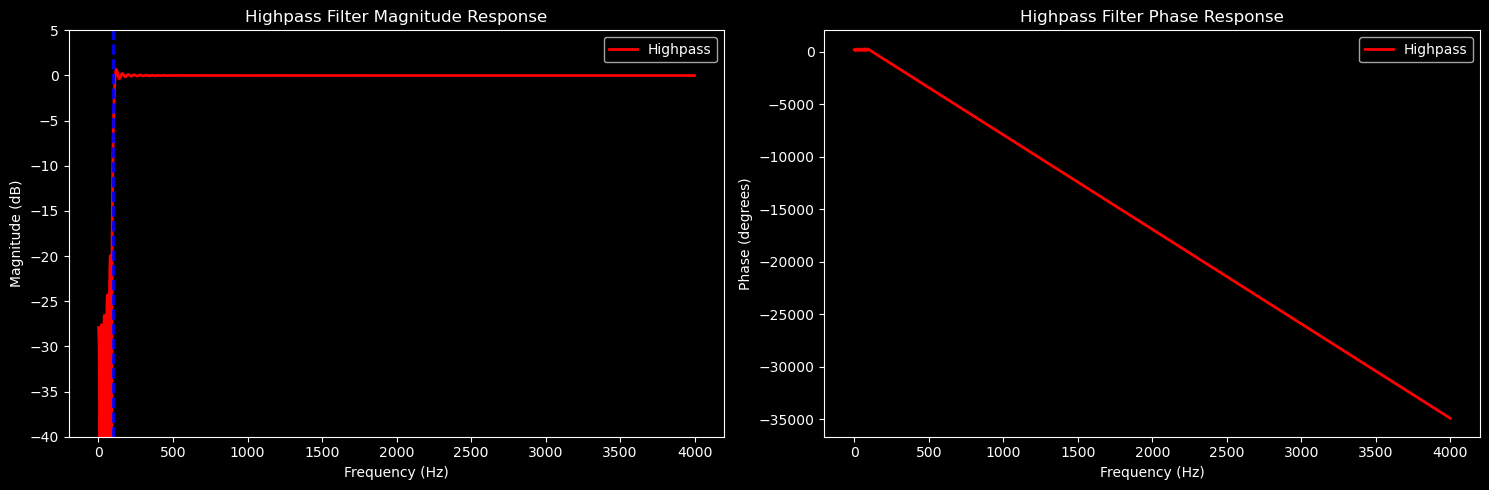

In [10]:
w, H_hp = freqz(b,a, worN=2048, fs=fs)

# --- Plot ---
plt.figure(figsize=(15, 5), facecolor='black')

# Magnitude Response
plt.subplot(1,2, 1)
plt.plot(w, 20*np.log10(np.abs(H_hp)), 'r', linewidth=2)
# plt.grid(True)
plt.axvline(CUTOFF_HZ, color='b', linestyle='--')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')
plt.title(f"{FILTER_TYPE.capitalize()} Filter Magnitude Response")
plt.legend(['Highpass'])
plt.ylim([-40, 5])

# Phase Response
plt.subplot(1, 2, 2)
plt.plot(w, np.unwrap(np.angle(H_hp)) * 180 / np.pi, 'r', linewidth=2)
# plt.grid(True)
plt.title(f"{FILTER_TYPE.capitalize()} Filter Phase Response")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (degrees)')
plt.legend(['Highpass'])

plt.tight_layout()
plt.show()

In [11]:
if USE_IIR:
    if FILTER_TYPE == "lowpass":
        bs = [as_coeffs[-1]]
    else:
        bs = [1.0] + [0.0] * FILTER_ORDER
        
    display(Markdown(rf"""<h1 style="font-size:{"50px"}; color:{"#2e7d32"}; text-align:center;">Designing {FILTER_TYPE} IIR Butterworth</h2>"""))

    s = symbols('s')
    num_s = sum(np.round(bs[i],4) * s**(len(bs)-1-i) for i in range(len(bs)))
    den_s = sum(np.round(as_coeffs[i],4) * s**(len(as_coeffs)-1-i) for i in range(len(as_coeffs)))
    H_s = simplify(num_s / den_s)
    
    display(Markdown(rf"## Analog Butterworth {FILTER_TYPE.upper()} Filter Transfer Function: H(s)"))
    display(Math(r"\displaystyle {\Large " + latex(H_s) + "}"))

    z = symbols('z')
    num_z = sum(np.round(b[k],4) * z**(-k) for k in range(len(b)))
    den_z = sum(np.round(a[k],4) * z**(-k) for k in range(len(a)))
    H_z = simplify(num_z / den_z)
    
    display(Markdown(rf"## Digital Butterworth {FILTER_TYPE.upper()} Filter Transfer Function: H(z) "))
    display(Math(r"\displaystyle {\large " + latex(H_z) + "}"))

    print("\nDiscrete Numerator Coefficients (bz):")
    print(f"   {np.array2string(b, formatter={'all':lambda x: f'{x:.4e}'})}")

    print("\nDiscrete Denominator Coefficients (az):")
    print(f"   {a}")
    
else:
    # ===============================
    # FIR Filter
    # ===============================
    print(f"\nDesigning {FILTER_TYPE} FIR filter")

    b, a = design_fir_rectangular(FILTER_TYPE, CUTOFF_HZ, fs, FIR_TAPS)

    z = symbols('z')

    H_z = simplify(sum(np.round(b[k],4) * z**(-k) for k in range(len(b))))
    print("\n### FIR Transfer Function H(z) ###")
    display(Math(r"\displaystyle {\Huge " + latex(H_z) + "}"))

    print("\nDiscrete Numerator Coefficients (bz):")
    print(f"   {np.array2string(b, formatter={'all':lambda x: f'{x:.20f}'}, separator='\n')}")


Designing highpass FIR filter

### FIR Transfer Function H(z) ###


<IPython.core.display.Math object>


Discrete Numerator Coefficients (bz):
   [-0.00000000000000000097
-0.00012549117714289772
-0.00025147233954688592
 -0.00037717421782260547
-0.00050182149954104878
-0.00062463745236541980
 -0.00074484860040787998
-0.00086168942653415675
-0.00097440707294252176
 -0.00108226601210615388
-0.00118455266009135697
-0.00128057990435096304
 -0.00136969151834280089
-0.00145126643573724630
-0.00152472285755502618
 -0.00158952216631362358
-0.00164517262215579160
-0.00169123281698233202
 -0.00172731486380868233
-0.00175308729990545243
-0.00176827768376000582
 -0.00177267486750216159
-0.00176613092816393295
-0.00174856274298173294
 -0.00171995319589014718
-0.00168035200438868709
-0.00162987615807606303
 -0.00156870996232869866
-0.00149710468283980442
-0.00141537778901948863
 -0.00132391179657269159
-0.00122315271190695865
-0.00111360808336288309
 -0.00099584466659336478
-0.00087048571372969215
-0.00073820789825003962
 -0.00059973788969540430
-0.00045584859454634387
-0.00030735508166841404
 -0.00015

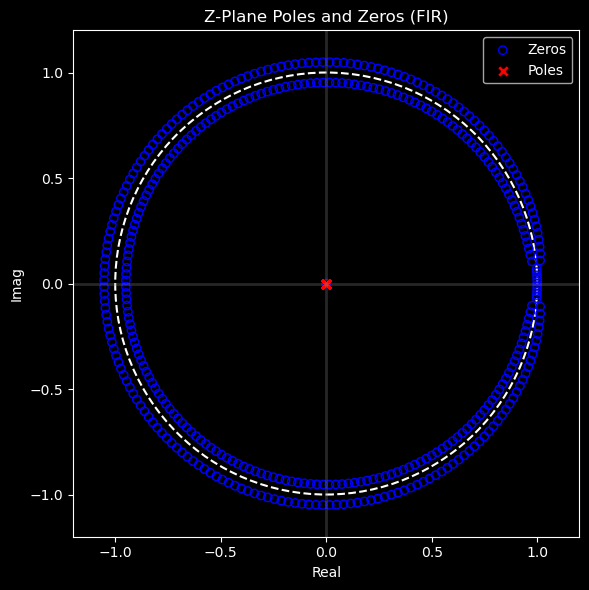

In [13]:
if USE_IIR:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # --- S-Plane (Analog) ---
    if p_an is not None:
        ax1.axhline(0, color="gray", alpha=0.3)
        ax1.axvline(0, color="gray", alpha=0.3)
        ax1.scatter(p_an.real, p_an.imag, color='red', marker='x', s=80, label="Analog Poles", zorder=9)
        ax1.set_title("S-Plane Poles (Analog Prototype)")
        ax1.set_xlabel("Real(s)")
        ax1.set_ylabel("Imag(s)")
        ax1.legend()
        ax1.axis('equal')
    else:
        ax1.axis('off')  

    # --- Z-Plane (Digital) ---
    zeros = np.roots(b)
    poles = np.roots(a)

    ax2.axhline(0, color='gray', alpha=0.3)
    ax2.axvline(0, color='gray', alpha=0.3)

    # Unit circle
    circle = plt.Circle((0,0), 1, edgecolor='white', fill=False, linestyle='--')
    ax2.add_artist(circle)

    # Plot poles & zeros
    ax2.scatter(zeros.real, zeros.imag, marker='o', edgecolors='blue', facecolors='none', label='Zeros')
    ax2.scatter(poles.real, poles.imag, marker='x', color='red', label='Poles')

    ax2.set_xlim(-1.2, 1.2)
    ax2.set_ylim(-1.2, 1.2)
    ax2.set_aspect('equal', 'box')
    ax2.set_title("Z-Plane Poles and Zeros")
    ax2.set_xlabel("Real")
    ax2.set_ylabel("Imag")
    ax2.legend()

else:
    fig, ax = plt.subplots(figsize=(6,6))

    zeros = np.roots(b)
    poles = np.zeros(len(b)-1)  # FIR poles at origin

    ax.axhline(0, color='gray', alpha=0.3)
    ax.axvline(0, color='gray', alpha=0.3)

    # Unit circle
    circle = plt.Circle((0,0), 1, edgecolor='White', fill=False, linestyle='--', lw=1.5)
    ax.add_artist(circle)

    # Plot poles & zeros
    ax.scatter(zeros.real, zeros.imag, marker='o', edgecolors='blue', facecolors='none', label='Zeros')
    ax.scatter(poles.real, poles.imag, marker='x', color='red', label='Poles')

    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal', 'box')
    ax.set_title("Z-Plane Poles and Zeros (FIR)")
    ax.set_xlabel("Real")
    ax.set_ylabel("Imag")
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 3) FFT before/after
nfft = 2**15
X = np.fft.rfft(audio_noisy, n=nfft)
Y = np.fft.rfft(filtered, n=nfft)
f = np.fft.rfftfreq(nfft, 1/fs)

plt.figure(figsize=(15, 4))
plt.semilogx(f, 20*np.log10(np.abs(X)+1e-12), label="Noisy Input")
plt.semilogx(f, 20*np.log10(np.abs(Y)+1e-12), label="Filtered")
plt.title("Spectrum Before vs After")
plt.axvline(CUTOFF_HZ, color='r', linestyle='--', alpha=0.7, label=f'Cutoff: {CUTOFF_HZ} Hz')
plt.xlabel("Hz")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.legend()
plt.xlim(1, fs)
plt.tight_layout()

In [ ]:
# 5) Spectrograms
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.specgram(audio_noisy, Fs=fs, NFFT=1024, noverlap=512)
plt.title("Noisy Input")
plt.ylim(0,  fs/2)

plt.subplot(1,2,2)
plt.specgram(filtered, Fs=fs, NFFT=1024, noverlap=512)
plt.title("Filtered Output")
plt.ylim(0,  fs/2)

plt.tight_layout()
plt.show()